In [103]:
# torch 임포트와 GPU 설정

In [104]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.13.1
GPU Available: True


In [105]:
# Implementing the generator and the discriminator networks

In [106]:
# 라이브러리 임포트
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
# 생성자 네트워크 정의
# input_size: 생성자의 입력 크기입니다 (여기서는 20).
# num_hidden_layers, num_hidden_units: 은닉층의 수와 각 은닉층의 뉴런(유닛) 수입니다.
# num_output_units: 생성자의 출력 크기입니다 (여기서는 784, 즉 28x28 이미지).
# nn.Linear: 완전 연결층을 만듭니다.
# nn.LeakyReLU: 활성화 함수로 Leaky ReLU를 사용합니다.
# nn.Tanh: 출력층의 활성화 함수로 하이퍼볼릭 탄젠트를 사용합니다.
def make_generator_network(
        input_size=20,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', 
                         nn.Linear(input_size, 
                                   num_hidden_units)) 
        model.add_module(f'relu_g{i}', 
                         nn.LeakyReLU())     
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}', 
                    nn.Linear(input_size, num_output_units))   
    model.add_module('tanh_g', nn.Tanh())      
    return model

# 판별자 네트워크 정의
# input_size: 판별자의 입력 크기입니다 (여기서는 784, 즉 28x28 이미지).
# num_hidden_layers, num_hidden_units: 은닉층의 수와 각 은닉층의 뉴런 수입니다.
# num_output_units: 판별자의 출력 크기입니다 (여기서는 1, 즉 실제 또는 가짜를 나타내는 하나의 값).
# nn.Dropout: 과적합을 방지하기 위해 드롭아웃 층을 추가합니다.
# nn.Sigmoid: 출력층의 활성화 함수로 시그모이드를 사용합니다.
def make_discriminator_network(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', 
                 nn.Linear(input_size, 
                           num_hidden_units, bias=False)) 
        model.add_module(f'relu_d{i}', 
                         nn.LeakyReLU())  
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}', 
                     nn.Linear(input_size, num_output_units))   
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [108]:
# 모델 설정 및 인스턴스 생성
# image_size, z_size, gen_hidden_layers, gen_hidden_size, disc_hidden_layers, disc_hidden_size는 각각 이미지 크기, 입력 벡터 크기, 은닉층의 개수 및 크기를 설정합니다.
# torch.manual_seed(1)은 난수 생성기의 시드를 설정합니다.
# make_generator_network와 make_discriminator_network 함수를 사용하여 생성자와 판별자 모델을 생성하고 초기화합니다.
# print(gen_model), print(disc_model)은 각 모델의 구조를 출력합니다.
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
 
print(gen_model)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [109]:
# Defining the training dataset

In [110]:
# 라이브러리 임포트 및 데이터셋 설정
# torchvision 라이브러리를 사용하여 MNIST 데이터셋을 불러옵니다.
# transforms.Compose는 데이터 전처리를 위한 함수들을 조합하는 방법입니다.
# transforms.ToTensor()는 이미지를 PyTorch 텐서로 변환합니다.
# transforms.Normalize()는 텐서의 값을 평균 0.5, 표준편차 0.5로 정규화하여 -1에서 1 사이의 값으로 조정합니다.
# mnist_dataset 객체를 생성할 때 위에서 정의한 변환(transform)을 적용하고, 데이터셋을 다운로드합니다.
import torchvision 
from torchvision import transforms 


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

In [111]:
# 데이터셋에서 샘플 이미지 추출 및 확인
# iter(mnist_dataset)를 통해 데이터셋을 순회할 수 있는 이터레이터를 생성하고, next() 함수로 첫 번째 샘플을 가져옵니다.
# 샘플 이미지의 최소값과 최대값을 출력하여 데이터가 올바르게 정규화되었는지 확인합니다 (-1에서 1).
# 샘플 이미지의 형태(shape)를 출력합니다 (1 x 28 x 28).
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [112]:
# 노이즈 생성 함수 정의
# create_noise 함수는 생성자에게 입력으로 줄 노이즈 벡터를 생성합니다.
# uniform 모드는 -1과 1 사이의 균등 분포에서 값을 생성하고, normal 모드는 표준 정규 분포에서 값을 생성합니다.
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [113]:
# 데이터 로더 및 입력 데이터 형태 설정
# DataLoader를 사용해 배치 크기만큼의 데이터를 불러올 수 있도록 설정합니다.
# 실제 데이터인 input_real은 배치 사이즈만큼 불러온 후, 1차원 벡터로 변환됩니다 (784).
from torch.utils.data import DataLoader


batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

In [114]:
# 노이즈 및 실제 데이터를 생성자 및 판별자에 입력하고 결과 확인
# torch.manual_seed(1)는 실험 결과를 일정하게 유지하기 위해 난수 생성기의 시드를 설정합니다.
# 생성자 gen_model에 노이즈 input_z를 입력하여 가짜 데이터인 g_output을 생성합니다.
# 판별자 disc_model는 실제 데이터 input_real과 가짜 데이터 g_output을 입력으로 받아 각각의 예측 확률 d_proba_real과 d_proba_fake를 출력합니다.
# 출력된 형태를 확인하여 데이터가 올바르게 처리되었는지 확인합니다.
torch.manual_seed(1)
mode_z = 'uniform'  # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [115]:
# Training the GAN model

In [116]:
# 손실 함수 설정
# loss_fn = nn.BCELoss()는 생성자(generator)와 판별자(discriminator)의 손실을 계산하기 위해 이진 교차 엔트로피(Binary Cross Entropy) 손실 함수를 설정합니다.
loss_fn = nn.BCELoss()

# 생성자 손실 계산
# g_labels_real = torch.ones_like(d_proba_fake)는 생성자가 만든 가짜 이미지에 대해 '실제'로 분류해야 할 레이블을 모두 1로 설정합니다.
# g_loss = loss_fn(d_proba_fake, g_labels_real)은 생성자가 만든 가짜 이미지가 실제로 간주될 확률을 기반으로 생성자의 손실을 계산합니다. 출력된 'Generator Loss'는 생성자가 얼마나 잘 속였는지를 나타냅니다.
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

# 판별자 손실 계산
# d_labels_real = torch.ones_like(d_proba_real)은 실제 이미지에 대한 레이블을, d_labels_fake = torch.zeros_like(d_proba_fake)는 가짜 이미지에 대한 레이블을 설정합니다.
# d_loss_real과 d_loss_fake는 판별자가 실제 이미지를 '실제'로, 가짜 이미지를 '가짜'로 올바르게 분류하는지를 평가하는 손실을 계산합니다. 출력된 'Discriminator Losses'는 판별자의 성능을 나타냅니다.
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6983
Discriminator Losses: Real 0.7479 Fake 0.6885


In [117]:
# 데이터셋 및 배치 설정
# mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)는 MNIST 데이터셋을 불러와서 배치 크기로 데이터를 처리하도록 DataLoader를 설정합니다.
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)
 
# 모델 설정
# gen_model = make_generator_network(...).to(device)는 생성자 네트워크를 설정하고, 사용할 장치(device)에 할당합니다.
# disc_model = make_discriminator_network(...).to(device)는 판별자 네트워크를 설정하고, 사용할 장치에 할당합니다.
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)
 
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)
 
# 손실 함수 및 최적화 함수 설정
# loss_fn = nn.BCELoss()로 손실 함수를 다시 설정합니다.
# g_optimizer = torch.optim.Adam(gen_model.parameters())는 생성자의 파라미터를 최적화하기 위한 Adam 최적화 함수를 설정합니다.
# d_optimizer = torch.optim.Adam(disc_model.parameters())는 판별자의 파라미터를 최적화하기 위한 Adam 최적화 함수를 설정합니다.
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [118]:
# 판별자 훈련
# 판별자의 그래디언트를 0으로 초기화합니다.
# 실제 이미지 배치를 판별자에 입력하여 실제로부터 나온 확률을 계산합니다.
# 실제 이미지 배치에 대한 손실을 계산합니다.
# 가짜 이미지 배치를 생성자로부터 생성하여 판별자에 입력합니다.
# 가짜 이미지 배치에 대한 손실을 계산합니다.
# 실제 및 가짜 이미지에 대한 손실을 합하여 그래디언트를 계산하고 역전파를 수행합니다.
# 판별자의 매개변수를 최적화합니다.
def d_train(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [119]:
# 생성자 훈련
# 생성자의 그래디언트를 0으로 초기화합니다.
# 임의의 노이즈로부터 가짜 이미지 배치를 생성합니다.
# 생성된 가짜 이미지를 판별자에 입력하여 가짜 이미지가 실제로 분류될 확률을 계산합니다.
# 생성자 손실을 계산하고 역전파를 통해 그래디언트를 계산합니다.
# 생성자의 매개변수를 최적화합니다.
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [120]:
# 고정된 노이즈로부터 샘플 생성
# 고정된 노이즈를 사용하여 생성자로부터 이미지를 생성합니다.
# 생성된 이미지를 원하는 형태로 변형합니다.
# 이미지 데이터를 정규화하여 반환합니다.
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

# 훈련과정
# 여러 에포크에 걸쳐 판별자와 생성자를 번갈아 가며 훈련합니다.
# 각 에포크마다 판별자와 생성자의 손실을 기록합니다.
# 판별자가 실제 이미지와 가짜 이미지를 얼마나 잘 구분하는지 확률을 기록합니다.
# 특정 에포크마다 생성자로부터 생성된 이미지 샘플을 기록합니다.

num_epochs = 50
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
        
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 0.8965/0.9033 [D-Real: 0.8048 D-Fake: 0.4707]
Epoch 002 | Avg Losses >> G/D 0.9047/1.1651 [D-Real: 0.6023 D-Fake: 0.4428]
Epoch 003 | Avg Losses >> G/D 0.9365/1.2375 [D-Real: 0.5630 D-Fake: 0.4379]
Epoch 004 | Avg Losses >> G/D 0.9379/1.2213 [D-Real: 0.5734 D-Fake: 0.4350]
Epoch 005 | Avg Losses >> G/D 0.9464/1.2172 [D-Real: 0.5740 D-Fake: 0.4236]
Epoch 006 | Avg Losses >> G/D 0.8279/1.3060 [D-Real: 0.5353 D-Fake: 0.4587]
Epoch 007 | Avg Losses >> G/D 0.9236/1.2420 [D-Real: 0.5612 D-Fake: 0.4346]
Epoch 008 | Avg Losses >> G/D 1.1072/1.1279 [D-Real: 0.6121 D-Fake: 0.3888]
Epoch 009 | Avg Losses >> G/D 1.0422/1.1497 [D-Real: 0.6047 D-Fake: 0.4016]
Epoch 010 | Avg Losses >> G/D 0.8911/1.2574 [D-Real: 0.5599 D-Fake: 0.4379]
Epoch 011 | Avg Losses >> G/D 0.8662/1.2740 [D-Real: 0.5514 D-Fake: 0.4451]
Epoch 012 | Avg Losses >> G/D 0.8681/1.2737 [D-Real: 0.5515 D-Fake: 0.4459]
Epoch 013 | Avg Losses >> G/D 0.9479/1.2241 [D-Real: 0.5749 D-Fake: 0.4256]
Epoch 014 | 

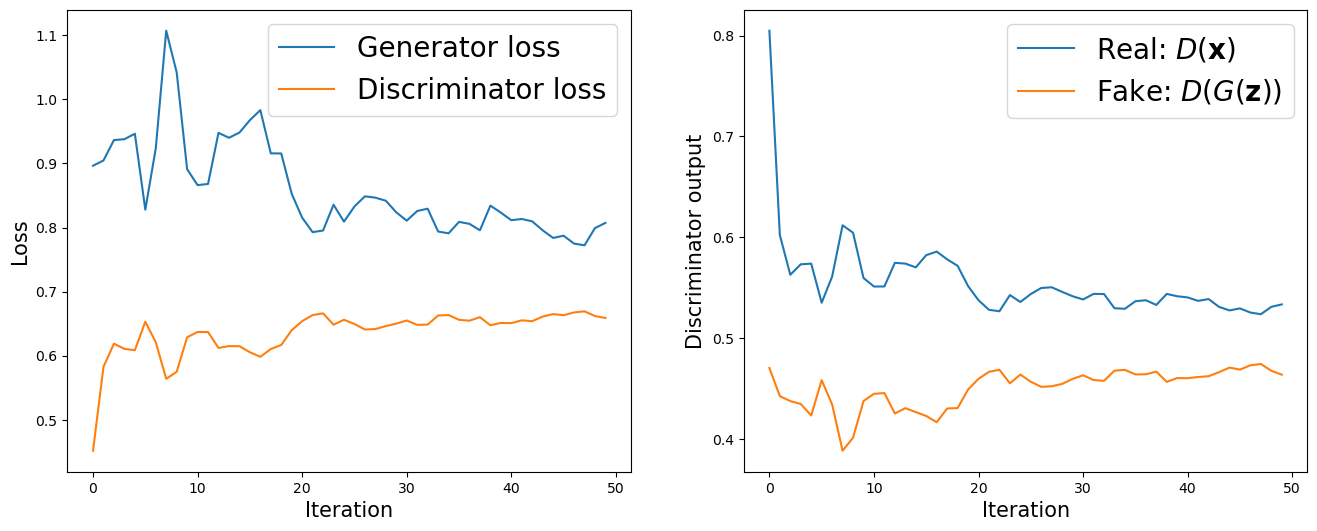

In [121]:
# matplotlib을 이용하여 훈련 중 생성자의 손실과 판별자의 손실을 선 그래프로 그립니다.
# 판별자가 실제 데이터와 가짜 데이터를 얼마나 잘 구분하지는지를 나타내는 출력 값을 선 그래프로 그립니다.
import itertools


fig = plt.figure(figsize=(16, 6))

# 손실 값 시각화
ax = fig.add_subplot(1, 2, 1)
 
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

# 판별자 출력 시각화
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.show()

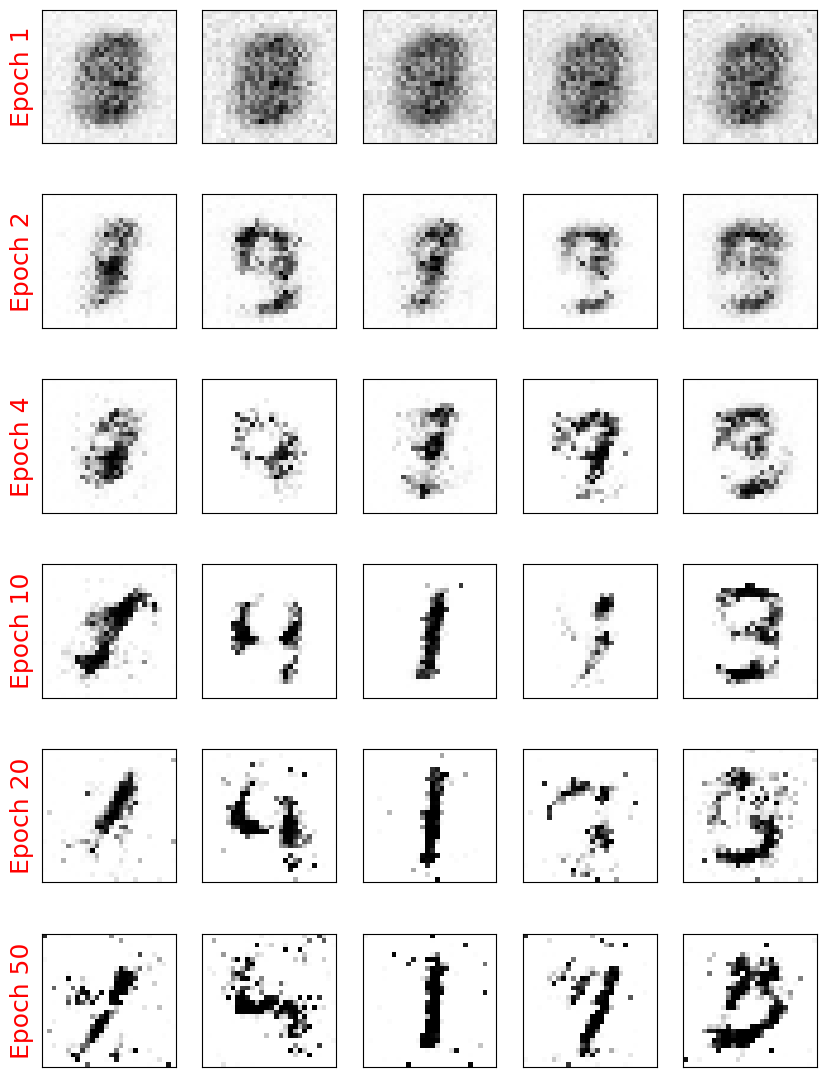

In [122]:
# 선택된 에포크에 대해 생성된 이미지를 시각화하여 생성자의 성능을 보여줍니다.
# 각 에포크에서 생성된 다양한 이미지 샘플을 표시하여 시간이 지남에 따라 생성자가 어떻게 발전하는지 확인 할 수 있습니다.
selected_epochs = [1, 2, 4, 10, 20, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()